Connect to the MongoDB database, and access the se collection of the datasets_test database. 
The reader user is only able to list data. 

In [1]:
import pymongo
client = pymongo.MongoClient(
    'mongodb://{}:{}@localhost/?authSource={}&authMechanism=MONGODB-CR'.format(
        'reader', 'MreaderO', 'datasets'
    )
)
col = client['datasets']['se']

Get all datasets. The first dataset is a test entry, we just remove it. 

In [4]:
import pprint
datasets = list(col.find({}))
pprint.pprint(datasets[0])
print(len(datasets))

{u'_id': ObjectId('5d10a88f19071538d23f37b3'),
 u'name': u'190503%HiggsSUSYGG80%tt_mssm_signals_Btagging_up',
 u'prod_date': u'190503',
 u'sample': u'HiggsSUSYGG80',
 u'sample_version': u'tt_mssm_signals_Btagging_up',
 u'sub_date': u'2019-05-18_05-34-50',
 u'sub_dir': u'/gridgroup/cms/touquet/crab_submission_dirs/crab_HiggsSUSYGG80_tt_mssm_signals_Btagging_up/crab_HiggsSUSYGG80_190503_tt_mssm_signals_Btagging_up_2019-05-18_05-34-50'}
3329


The information obtained from the submission directory and from the corresponding output directory on the SE is stored in a dictionary. In the case above, the output directory did not yet appear on the SE. 

Let's find the datasets where this is the case: 

In [14]:
se_datasets = [ds for ds in datasets if 'path' in ds]
print(len(se_datasets))
pprint.pprint(se_datasets[0])

2884
{u'_id': ObjectId('5d10a88c19071538d23f336b'),
 u'name': u'190503%HiggsSUSYGG200%tt_mssm_signals_CMS_scale_j_RelativeSample_13TeV_up',
 u'path': u'/store/user/gtouquet/heppyTrees/190503/tt_mssm_signals_CMS_scale_j_RelativeSample_13TeV_up/HiggsSUSYGG200/190518_014140',
 u'prod_date': u'190503',
 u'sample': u'HiggsSUSYGG200',
 u'sample_version': u'tt_mssm_signals_CMS_scale_j_RelativeSample_13TeV_up',
 u'sub_date': u'2019-05-18_03-39-15',
 u'sub_dir': u'/gridgroup/cms/touquet/crab_submission_dirs/crab_HiggsSUSYGG200_tt_mssm_signals_CMS_scale_j_RelativeSample_13TeV_up/crab_HiggsSUSYGG200_190503_tt_mssm_signals_CMS_scale_j_RelativeSample_13TeV_up_2019-05-18_03-39-15',
 u'subdir_pattern': u'*',
 u'subdirs': [u'0000'],
 u'tgz_pattern': u'*',
 u'tgzs': {u'0000': [u'heppyOutput_1.tgz']},
 u'write_date': u'190518_014140'}


A bit or preprocessing. We are going to read the tgzs field to find out how many chunks are in the dataset, and to estimate the fraction of missing chunks. In case the dataset is not present on the SE, we just set 

For now, we assume that the largest chunk number is the number of chunks. This will underestimate computing efficiency, in case the last chunks are missing. 

You can edit the preprocessing function to add what you need in the dataset information. 

In [17]:
import pprint
import re

pattern = re.compile('.*_(\d+)\.tgz$')
def preprocess_chunks(datasets): 
    for ds in datasets: 
        tgzs = ds.get('tgzs', None)
        if tgzs is None:
            ds['nchunks'] = 0
            ds['chunk_ids'] = []
            ds['max_id'] = 99 # dummy value
            continue
        chunks = []
        if len(tgzs)!=1: 
            print('warning, need to see how to deal with 0000,0001, etc')
        for subd, subdchunks in tgzs.iteritems(): 
            # we do not consider the subdirectory, e.g. 0000
            chunks.extend(subdchunks)
        # find max integer
        ids = []
        for chunk in chunks: 
            # print(chunk)
            m = pattern.match(chunk)
            if m: 
                theid = int(m.group(1))
                # print(theid) 
                ids.append(theid)
        ds['nchunks'] = len(chunks)
        ds['chunk_ids'] = sorted(ids)
        ds['max_id'] = max(ids)

In [18]:
preprocess_chunks(datasets)
print(datasets[500])

{u'subdir_pattern': u'*', u'tgz_pattern': u'*', u'name': u'190503%TTSemi_pow%tt_TTbar_CMS_scale_j_eta3to5_13TeV_up', u'sub_date': u'2019-05-04_15-35-23', 'nchunks': 42, u'subdirs': [u'0000'], u'prod_date': u'190503', u'sample': u'TTSemi_pow', 'chunk_ids': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42], u'sub_dir': u'/gridgroup/cms/touquet/crab_submission_dirs/crab_TTSemi_pow_tt_TTbar_CMS_scale_j_eta3to5_13TeV_up/crab_TTSemi_pow_190503_tt_TTbar_CMS_scale_j_eta3to5_13TeV_up_2019-05-04_15-35-23', u'tgzs': {u'0000': [u'heppyOutput_1.tgz', u'heppyOutput_10.tgz', u'heppyOutput_11.tgz', u'heppyOutput_12.tgz', u'heppyOutput_13.tgz', u'heppyOutput_14.tgz', u'heppyOutput_15.tgz', u'heppyOutput_16.tgz', u'heppyOutput_17.tgz', u'heppyOutput_18.tgz', u'heppyOutput_19.tgz', u'heppyOutput_2.tgz', u'heppyOutput_20.tgz', u'heppyOutput_21.tgz', u'heppyOutput_22.tgz', u'heppyOutput_23.tgz', u'

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

In [20]:
df = pd.DataFrame(datasets)
df.head()

,_id,chunk_ids,max_id,name,nchunks,path,prod_date,sample,sample_version,sub_date,sub_dir,subdir_pattern,subdirs,tgz_pattern,tgzs,write_date
0,5d10a88f19071538d23f37b3,[],99,190503%HiggsSUSYGG80%tt_mssm_signals_Btagging_up,0,NaN,190503,HiggsSUSYGG80,tt_mssm_signals_Btagging_up,2019-05-18_05-34-50,/gridgroup/cms/touquet/crab_submission_dirs/cr...,NaN,NaN,NaN,NaN,NaN
1,5d10a88f19071538d23f37b9,[],99,190503%HiggsVBF125%tt_sm_higgs_METunclustered_up,0,NaN,190503,HiggsVBF125,tt_sm_higgs_METunclustered_up,2019-05-10_23-27-40,/gridgroup/cms/touquet/crab_submission_dirs/cr...,NaN,NaN,NaN,NaN,NaN
2,5d10a88f19071538d23f3771,[],99,190503%HiggsSUSYGG250%tt_mssm_signals_CMS_scal...,0,NaN,190503,HiggsSUSYGG250,tt_mssm_signals_CMS_scale_j_RelativeBal_13TeV_...,2019-05-15_18-57-33,/gridgroup/cms/touquet/crab_submission_dirs/cr...,NaN,NaN,NaN,NaN,NaN
3,5d10a88f19071538d23f3787,[],99,190503%HiggsSUSYBB90%tt_mssm_signals_TES_Hadro...,0,NaN,190503,HiggsSUSYBB90,tt_mssm_signals_TES_HadronicTau_3prong0pi0_down,2019-05-18_13-33-15,/gridgroup/cms/touquet/crab_submission_dirs/cr...,NaN,NaN,NaN,NaN,NaN
4,5d10a88f19071538d23f379c,[],99,190503%HiggsSUSYGG3200%tt_mssm_signals_Btaggin...,0,NaN,190503,HiggsSUSYGG3200,tt_mssm_signals_Btagging_up,2019-05-18_06-44-07,/gridgroup/cms/touquet/crab_submission_dirs/cr...,NaN,NaN,NaN,NaN,NaN


## number of chunks

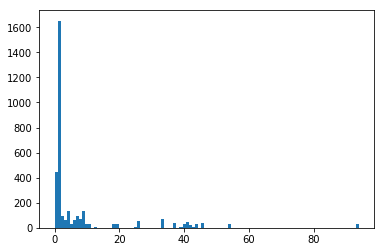

In [21]:
_ = plt.hist(df['nchunks'], bins=100)

## fraction of missing chunks

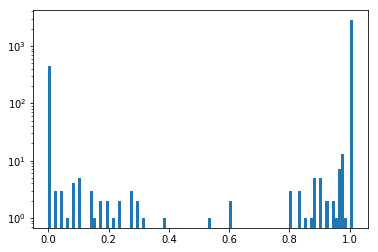

In [22]:
_ = plt.hist(df['nchunks']/df['max_id'], bins=101, range=(0,1.01))
plt.yscale('log')

Filter datasets with a low fraction. First we add the fraction to the dataframe

In [23]:
df['missfrac'] = df['nchunks']/df['max_id']

In [24]:
df[df['missfrac']<0.5]

,_id,chunk_ids,max_id,name,nchunks,path,prod_date,sample,sample_version,sub_date,sub_dir,subdir_pattern,subdirs,tgz_pattern,tgzs,write_date,missfrac
0,5d10a88f19071538d23f37b3,[],99,190503%HiggsSUSYGG80%tt_mssm_signals_Btagging_up,0,NaN,190503,HiggsSUSYGG80,tt_mssm_signals_Btagging_up,2019-05-18_05-34-50,/gridgroup/cms/touquet/crab_submission_dirs/cr...,NaN,NaN,NaN,NaN,NaN,0.000000
1,5d10a88f19071538d23f37b9,[],99,190503%HiggsVBF125%tt_sm_higgs_METunclustered_up,0,NaN,190503,HiggsVBF125,tt_sm_higgs_METunclustered_up,2019-05-10_23-27-40,/gridgroup/cms/touquet/crab_submission_dirs/cr...,NaN,NaN,NaN,NaN,NaN,0.000000
2,5d10a88f19071538d23f3771,[],99,190503%HiggsSUSYGG250%tt_mssm_signals_CMS_scal...,0,NaN,190503,HiggsSUSYGG250,tt_mssm_signals_CMS_scale_j_RelativeBal_13TeV_...,2019-05-15_18-57-33,/gridgroup/cms/touquet/crab_submission_dirs/cr...,NaN,NaN,NaN,NaN,NaN,0.000000
3,5d10a88f19071538d23f3787,[],99,190503%HiggsSUSYBB90%tt_mssm_signals_TES_Hadro...,0,NaN,190503,HiggsSUSYBB90,tt_mssm_signals_TES_HadronicTau_3prong0pi0_down,2019-05-18_13-33-15,/gridgroup/cms/touquet/crab_submission_dirs/cr...,NaN,NaN,NaN,NaN,NaN,0.000000
4,5d10a88f19071538d23f379c,[],99,190503%HiggsSUSYGG3200%tt_mssm_signals_Btaggin...,0,NaN,190503,HiggsSUSYGG3200,tt_mssm_signals_Btagging_up,2019-05-18_06-44-07,/gridgroup/cms/touquet/crab_submission_dirs/cr...,NaN,NaN,NaN,NaN,NaN,0.000000
5,5d10a88f19071538d23f379d,[],99,190503%HiggsSUSYGG130%tt_mssm_signals_TES_prom...,0,NaN,190503,HiggsSUSYGG130,tt_mssm_signals_TES_promptMuon_1prong0pi0_up,2019-05-15_09-58-20,/gridgroup/cms/touquet/crab_submission_dirs/cr...,NaN,NaN,NaN,NaN,NaN,0.000000
6,5d10a88f19071538d23f379e,[],99,190503%HiggsSUSYBB2900%tt_mssm_signals_CMS_sca...,0,NaN,190503,HiggsSUSYBB2900,tt_mssm_signals_CMS_scale_j_RelativeSample_13T...,2019-05-18_05-30-02,/gridgroup/cms/touquet/crab_submission_dirs/cr...,NaN,NaN,NaN,NaN,NaN,0.000000
7,5d10a88f19071538d23f379f,[],99,190503%HiggsSUSYGG900%tt_mssm_signals_Btagging_up,0,NaN,190503,HiggsSUSYGG900,tt_mssm_signals_Btagging_up,2019-05-18_06-18-20,/gridgroup/cms/touquet/crab_submission_dirs/cr...,NaN,NaN,NaN,NaN,NaN,0.000000
8,5d10a88f19071538d23f37a1,[],99,190503%HiggsSUSYBB110%tt_mssm_signals_TES_prom...,0,NaN,190503,HiggsSUSYBB110,tt_mssm_signals_TES_promptEle_1prong0pi0_down,2019-05-18_02-19-26,/gridgroup/cms/touquet/crab_submission_dirs/cr...,NaN,NaN,NaN,NaN,NaN,0.000000
9,5d10a88f19071538d23f37a3,[],99,190503%HiggsSUSYGG900%tt_mssm_signals_CMS_scal...,0,NaN,190503,HiggsSUSYGG900,tt_mssm_signals_CMS_scale_j_RelativeSample_13T...,2019-05-18_04-01-53,/gridgroup/cms/touquet/crab_submission_dirs/cr...,NaN,NaN,NaN,NaN,NaN,0.000000


Look for datasets completely missing on the SE: 

In [35]:
dfmissing = df.loc[df['nchunks']==0]
dfmissing

,_id,chunk_ids,max_id,name,nchunks,path,prod_date,sample,sample_version,sub_date,sub_dir,subdir_pattern,subdirs,tgz_pattern,tgzs,write_date,missfrac
0,5d10a88f19071538d23f37b3,[],99,190503%HiggsSUSYGG80%tt_mssm_signals_Btagging_up,0,NaN,190503,HiggsSUSYGG80,tt_mssm_signals_Btagging_up,2019-05-18_05-34-50,/gridgroup/cms/touquet/crab_submission_dirs/crab_HiggsSUSYGG80_tt_mssm_signals_Btagging_up/crab_HiggsSUSYGG80_190503_tt_mssm_signals_Btagging_up_2019-05-18_05-34-50,NaN,NaN,NaN,NaN,NaN,0.0
1,5d10a88f19071538d23f37b9,[],99,190503%HiggsVBF125%tt_sm_higgs_METunclustered_up,0,NaN,190503,HiggsVBF125,tt_sm_higgs_METunclustered_up,2019-05-10_23-27-40,/gridgroup/cms/touquet/crab_submission_dirs/crab_HiggsVBF125_tt_sm_higgs_METunclustered_up/crab_HiggsVBF125_190503_tt_sm_higgs_METunclustered_up_2019-05-10_23-27-40,NaN,NaN,NaN,NaN,NaN,0.0
2,5d10a88f19071538d23f3771,[],99,190503%HiggsSUSYGG250%tt_mssm_signals_CMS_scale_j_RelativeBal_13TeV_down,0,NaN,190503,HiggsSUSYGG250,tt_mssm_signals_CMS_scale_j_RelativeBal_13TeV_down,2019-05-15_18-57-33,/gridgroup/cms/touquet/crab_submission_dirs/crab_HiggsSUSYGG250_tt_mssm_signals_CMS_scale_j_RelativeBal_13TeV_down/crab_HiggsSUSYGG250_190503_tt_mssm_signals_CMS_scale_j_RelativeBal_13TeV_down_2019-05-15_18-57-33,NaN,NaN,NaN,NaN,NaN,0.0
3,5d10a88f19071538d23f3787,[],99,190503%HiggsSUSYBB90%tt_mssm_signals_TES_HadronicTau_3prong0pi0_down,0,NaN,190503,HiggsSUSYBB90,tt_mssm_signals_TES_HadronicTau_3prong0pi0_down,2019-05-18_13-33-15,/gridgroup/cms/touquet/crab_submission_dirs/crab_HiggsSUSYBB90_tt_mssm_signals_TES_HadronicTau_3prong0pi0_down/crab_HiggsSUSYBB90_190503_tt_mssm_signals_TES_HadronicTau_3prong0pi0_down_2019-05-18_13-33-15,NaN,NaN,NaN,NaN,NaN,0.0
4,5d10a88f19071538d23f379c,[],99,190503%HiggsSUSYGG3200%tt_mssm_signals_Btagging_up,0,NaN,190503,HiggsSUSYGG3200,tt_mssm_signals_Btagging_up,2019-05-18_06-44-07,/gridgroup/cms/touquet/crab_submission_dirs/crab_HiggsSUSYGG3200_tt_mssm_signals_Btagging_up/crab_HiggsSUSYGG3200_190503_tt_mssm_signals_Btagging_up_2019-05-18_06-44-07,NaN,NaN,NaN,NaN,NaN,0.0
5,5d10a88f19071538d23f379d,[],99,190503%HiggsSUSYGG130%tt_mssm_signals_TES_promptMuon_1prong0pi0_up,0,NaN,190503,HiggsSUSYGG130,tt_mssm_signals_TES_promptMuon_1prong0pi0_up,2019-05-15_09-58-20,/gridgroup/cms/touquet/crab_submission_dirs/crab_HiggsSUSYGG130_tt_mssm_signals_TES_promptMuon_1prong0pi0_up/crab_HiggsSUSYGG130_190503_tt_mssm_signals_TES_promptMuon_1prong0pi0_up_2019-05-15_09-58-20,NaN,NaN,NaN,NaN,NaN,0.0
6,5d10a88f19071538d23f379e,[],99,190503%HiggsSUSYBB2900%tt_mssm_signals_CMS_scale_j_RelativeSample_13TeV_up,0,NaN,190503,HiggsSUSYBB2900,tt_mssm_signals_CMS_scale_j_RelativeSample_13TeV_up,2019-05-18_05-30-02,/gridgroup/cms/touquet/crab_submission_dirs/crab_HiggsSUSYBB2900_tt_mssm_signals_CMS_scale_j_RelativeSample_13TeV_up/crab_HiggsSUSYBB2900_190503_tt_mssm_signals_CMS_scale_j_RelativeSample_13TeV_up_2019-05-18_05-30-02,NaN,NaN,NaN,NaN,NaN,0.0
7,5d10a88f19071538d23f379f,[],99,190503%HiggsSUSYGG900%tt_mssm_signals_Btagging_up,0,NaN,190503,HiggsSUSYGG900,tt_mssm_signals_Btagging_up,2019-05-18_06-18-20,/gridgroup/cms/touquet/crab_submission_dirs/crab_HiggsSUSYGG900_tt_mssm_signals_Btagging_up/crab_HiggsSUSYGG900_190503_tt_mssm_signals_Btagging_up_2019-05-18_06-18-20,NaN,NaN,NaN,NaN,NaN,0.0
8,5d10a88f19071538d23f37a1,[],99,190503%HiggsSUSYBB110%tt_mssm_signals_TES_promptEle_1prong0pi0_down,0,NaN,190503,HiggsSUSYBB110,tt_mssm_signals_TES_promptEle_1prong0pi0_down,2019-05-18_02-19-26,/gridgroup/cms/touquet/crab_submission_dirs/crab_HiggsSUSYBB110_tt_mssm_signals_TES_promptEle_1prong0pi0_down/crab_HiggsSUSYBB110_190503_tt_mssm_signals_TES_promptEle_1prong0pi0_down_2019-05-18_02-19-26,NaN,NaN,NaN,NaN,NaN,0.0
9,5d10a88f19071538d23f37a3,[],99,190503%HiggsSUSYGG900%tt_mssm_signals_CMS_scale_j_RelativeSample_13TeV_up,0,NaN,190503,HiggsSUSYGG900,tt_mssm_signals_CMS_scale_j_RelativeSample_13TeV_up,2019-05-18_04-01-53,/gridgroup/cms/touquet/crab_submission_dirs/crab_HiggsSUSYGG900_tt_mssm_signals_CMS_scale_

## Looking for a dataset

In [31]:
# select a dy jet sample
susygg80 = df.loc[df['name']=='190503%HiggsSUSYGG80%tt_mssm_signals_Btagging_up']
# print paths
pd.set_option('display.max_colwidth', 500)
susygg80

,_id,chunk_ids,max_id,name,nchunks,path,prod_date,sample,sample_version,sub_date,sub_dir,subdir_pattern,subdirs,tgz_pattern,tgzs,write_date,missfrac
0,5d10a88f19071538d23f37b3,[],99,190503%HiggsSUSYGG80%tt_mssm_signals_Btagging_up,0,NaN,190503,HiggsSUSYGG80,tt_mssm_signals_Btagging_up,2019-05-18_05-34-50,/gridgroup/cms/touquet/crab_submission_dirs/crab_HiggsSUSYGG80_tt_mssm_signals_Btagging_up/crab_HiggsSUSYGG80_190503_tt_mssm_signals_Btagging_up_2019-05-18_05-34-50,NaN,NaN,NaN,NaN,NaN,0.0
